In [27]:
import torch
import pandas as pd
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch_geometric.nn import GCNConv
import torch_geometric.utils as pyg_utils
from sklearn.preprocessing import LabelEncoder



In [28]:
# Load the CSV file
df = pd.read_csv('../facebook_clean_data/tvshow_edges.csv')

In [29]:
# Create a NetworkX graph from the edge list
G = nx.from_pandas_edgelist(df, 'node_1', 'node_2')

# If your nodes are not integers, encode them
le = LabelEncoder()
le.fit(list(G.nodes))
df['node_1'] = le.transform(df['node_1'])
df['node_2'] = le.transform(df['node_2'])


G = nx.from_pandas_edgelist(df, 'node_1', 'node_2')

# Convert the NetworkX graph to PyTorch Geometric format
data = pyg_utils.from_networkx(G)

num_nodes = data.num_nodes
data.x = torch.eye(num_nodes)

data.y = torch.randint(0, 2, (num_nodes,))

data.train_mask = torch.rand(num_nodes) < 0.8
data.test_mask = ~data.train_mask

print(data)

Data(edge_index=[2, 34501], num_nodes=3892, x=[3892, 3892], y=[3892], train_mask=[3892], test_mask=[3892])


In [30]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [31]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [32]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [33]:
model = GCN(num_node_features=data.num_features, hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f'Loss: {loss.item()}')  # Print the loss inside the function

for epoch in range(200):
    train()
    print(f'Epoch {epoch+1} completed.')

Loss: 4.158682346343994
Epoch 1 completed.
Loss: 4.088694095611572
Epoch 2 completed.
Loss: 4.0018768310546875
Epoch 3 completed.
Loss: 3.8960440158843994
Epoch 4 completed.
Loss: 3.7704949378967285
Epoch 5 completed.
Loss: 3.624305009841919
Epoch 6 completed.
Loss: 3.4574077129364014
Epoch 7 completed.
Loss: 3.270151138305664
Epoch 8 completed.
Loss: 3.063584566116333
Epoch 9 completed.
Loss: 2.8397552967071533
Epoch 10 completed.
Loss: 2.6023521423339844
Epoch 11 completed.
Loss: 2.3571150302886963
Epoch 12 completed.
Loss: 2.111948251724243
Epoch 13 completed.
Loss: 1.8763720989227295
Epoch 14 completed.
Loss: 1.6599243879318237
Epoch 15 completed.
Loss: 1.4700013399124146
Epoch 16 completed.
Loss: 1.310250997543335
Epoch 17 completed.
Loss: 1.180444598197937
Epoch 18 completed.
Loss: 1.0775953531265259
Epoch 19 completed.
Loss: 0.9974233508110046
Epoch 20 completed.
Loss: 0.9354719519615173
Epoch 21 completed.
Loss: 0.8877263069152832
Epoch 22 completed.
Loss: 0.8508504033088684
Ep

In [34]:
model.eval()
_, pred = model(data).max(dim=1)
correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
acc = correct / data.test_mask.sum().item()
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.4738


In [35]:

def community_detection(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(embeddings.detach().numpy())
    return clusters

embeddings = model(data)
clusters = community_detection(embeddings)

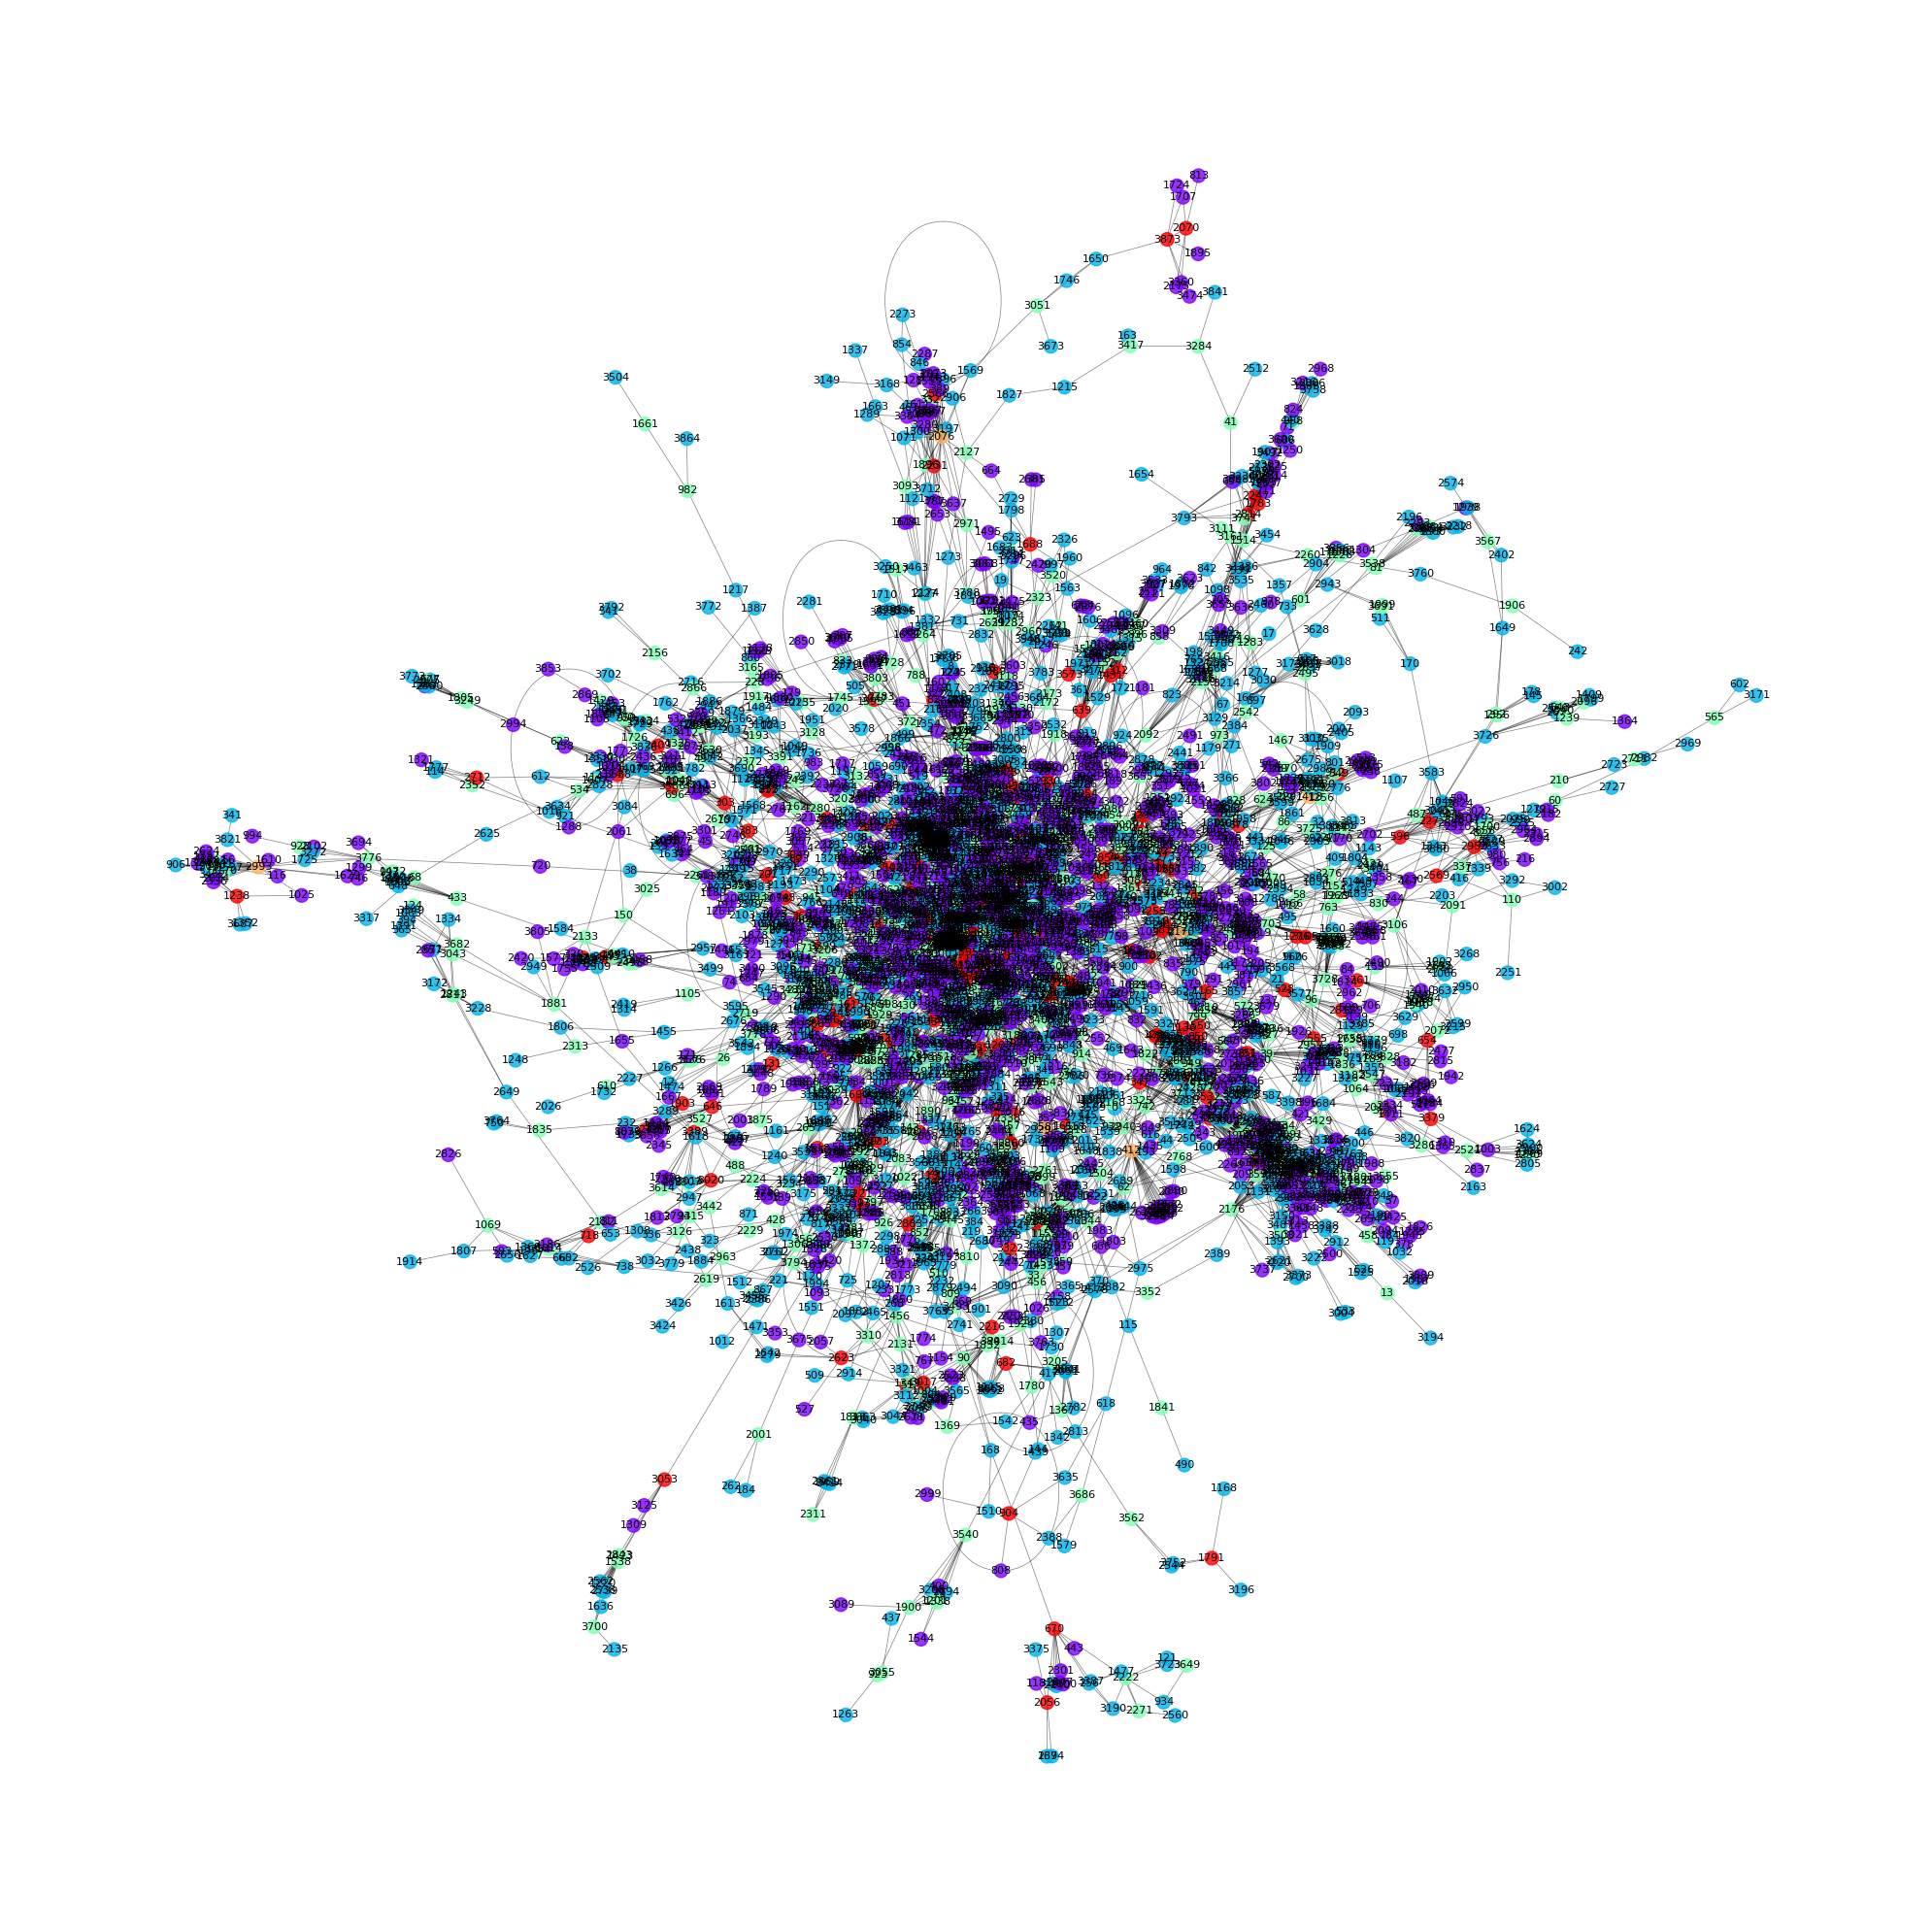

In [37]:
def visualize_communities(G, clusters):
    plt.figure(figsize=(20, 20))  # Set a larger figure size
    pos = nx.spring_layout(G, k=0.1, iterations=200)  # Adjust layout for better spacing

    # Draw nodes with community clusters
    nx.draw_networkx_nodes(G, pos, node_color=clusters, cmap=plt.cm.rainbow, 
                           node_size=100, alpha=0.8)
    
    # Draw edges with reduced opacity
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.5)

    # Optionally, you can draw labels if the graph isn't too dense
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

    # Remove axis for better visual appeal
    plt.axis('off')
    plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
    plt.show()

visualize_communities(G, clusters)